In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns
import plotly.express as px
import nbformat
import plotly.io as pio
pio.renderers.default = 'browser'
import folium
import webbrowser
import reportlab
import plotly.graph_objects as go
import plotly.offline as pyo
import html
from IPython.display import display, HTML



In [6]:
# Load data from a CSV file
df = pd.read_csv(r'C:\Users\izama\Desktop\immo-eliza-team6-analysis\immo-eliza-team6-analysis\data\clean\after_step_4_correlation.csv')

Text(0.5, 211.85316792101062, 'Longitude')

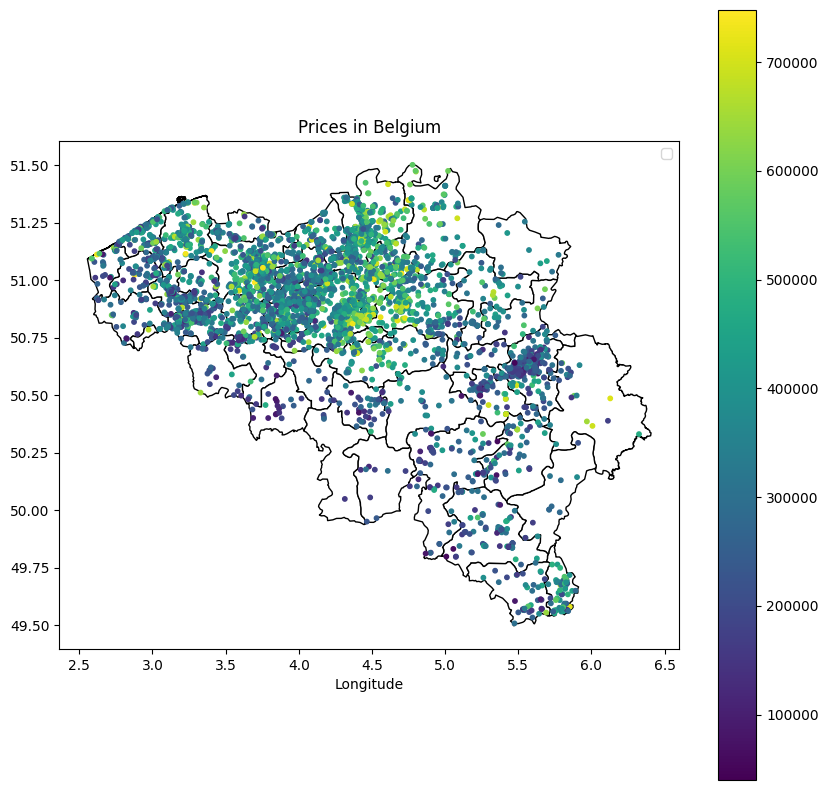

In [7]:
# Load data from a CSV file
df = pd.read_csv(r'C:\Users\izama\Desktop\immo-eliza-team6-analysis\immo-eliza-team6-analysis\data\clean\after_step_4_correlation.csv')

# Creating point geometry with Longitude and Latitude
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Setting the reference frame (CRS), e.g. EPSG:4326
gdf.set_crs(epsg=4326, inplace=True)

# Load administrative boundaries (e.g. Belgium)
# Replace 'path/to/belgium_shapefile.shp' with the path to your file
# Downloaded from: https://gadm.org/download_country.html#google_vignette
borders = gpd.read_file(r"C:\Users\izama\Desktop\gadm41_BEL_shp\gadm41_BEL_3.shp")

# Set the frame of reference for the boundaries if different (for example EPSG:4326)
#borders = borders.to_crs(epsg=4326)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Draw administrative boundaries on the map
borders.plot(ax=ax, color='white', edgecolor='black', linewidth=1) 

# Draw price points (Price)
scatter = gdf.plot(ax=ax, 
                   column='Price', 
                   cmap='viridis',  # Color map
                   legend=True, 
                   markersize=10)

# Add a legend
handles, labels = scatter.get_legend_handles_labels()
ax.legend(handles, [f'{int(float(label))}' for label in labels])

plt.title('Prices in Belgium')
plt.xlabel('Longitude')
##plt.ylabel('Latitude')
#plt.grid()
#plt.show()


**Correlation of real estate features (Seaborn)**

Correlation matrix to examine the correlations between different numeric variables 
like Price, Number_of_bedrooms, Living_area, Number_of_facades, etc.

<Axes: >

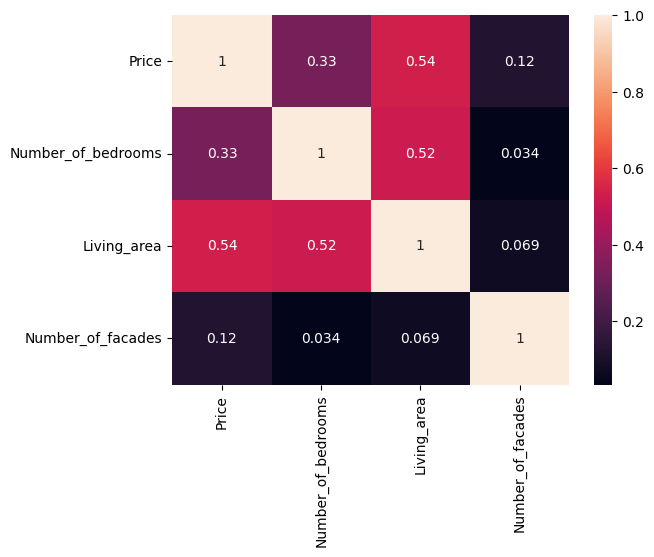

In [8]:
sns.heatmap(df[['Price', 'Number_of_bedrooms', 'Living_area', 'Number_of_facades']].corr(), annot=True)


**Histogram of real estate price distribution (Seaborn)**

Create a histogram showing the price distribution (Price) for different property types 
(Subtype) to see what prices dominate for different building types.

<Axes: xlabel='Price', ylabel='Count'>

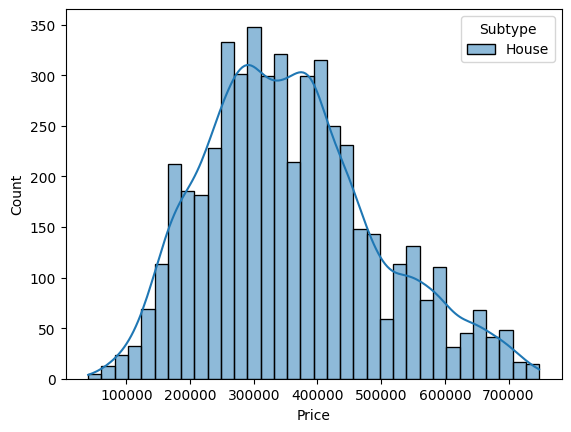

In [9]:
sns.histplot(data=df, x='Price', hue='Subtype', kde=True)

**Relationship between number of bedrooms and price (Seaborn)**

A scatterplot showing the relationship between Number_of_bedrooms and Price to see how the number of bedrooms affects price.

<Axes: xlabel='Number_of_bedrooms', ylabel='Price'>

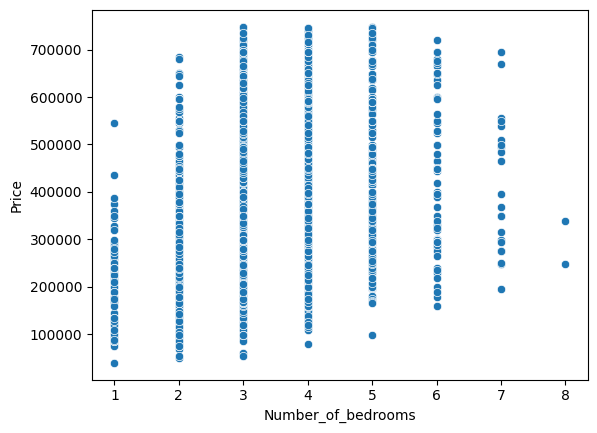

In [10]:
sns.scatterplot(data=df, x='Number_of_bedrooms', y='Price')


**Distribution of price per square meter (price_per_sqm) in different locations (Plotly)**

An interactive boxplot that shows the distribution of price per square meter (price_per_sqm) across different locations (locality_name).

In [11]:
fig = px.box(df, x='locality_name', y='price_per_sqm')
fig.show()


**Bar chart of number of rooms vs. living area (Seaborn)**

Bar chart showing average living area (Living_area) versus number of rooms (Number_of_bedrooms)

<Axes: xlabel='Number_of_bedrooms', ylabel='Living_area'>

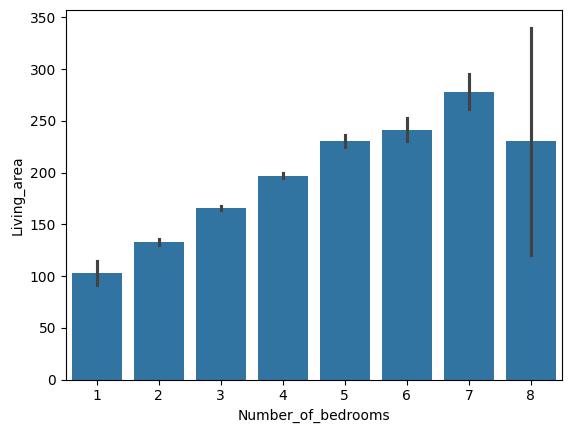

In [12]:
sns.barplot(data=df, x='Number_of_bedrooms', y='Living_area')


**The relationship between the condition of the building and the price**

The relationship between State_of_building and Price to see how the state of the building affects the value of the property.

<Axes: xlabel='State_of_building', ylabel='Price'>

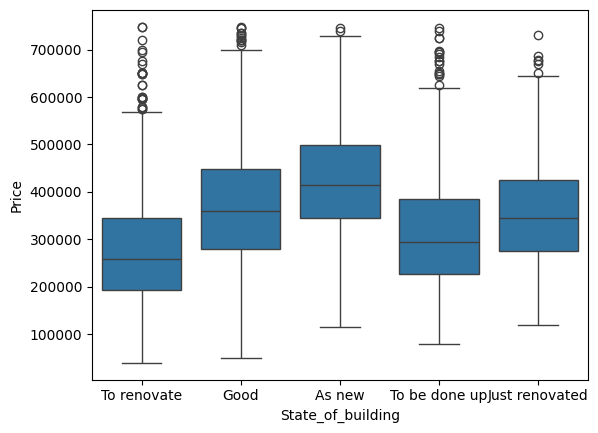

In [13]:
sns.boxplot(data=df, x='State_of_building', y='Price')


In [16]:
epc_categories = ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']


df['epc'] = pd.Categorical(df['epc'], categories=epc_categories, ordered=True)
df_sorted = df.sort_values('epc')


fig = px.scatter(df_sorted, x='epc', y='Price',
                 size='Living_area', color='epc',
                 hover_name='locality_name', 
                 title='Price depending on the EPC',
                 labels={'epc': 'EPC', 'Price': 'Price'},
                 size_max=20,
                 category_orders={'epc': epc_categories})

plot_file = 'epc_price_scatter.html'
pyo.plot(fig, filename=plot_file, include_plotlyjs='cdn', auto_open=False)


with open(plot_file, 'r') as f:
    html_content = f.read()

display(HTML(html_content))
pio.show(fig)


**Creating a histogram of real estate prices by building type**

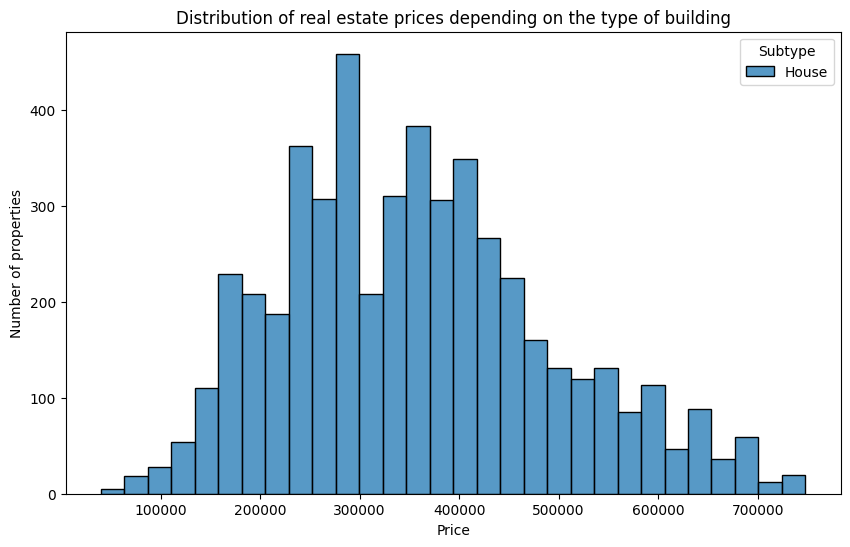

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Price', hue='Subtype', multiple='stack', bins=30)

plt.title('Distribution of real estate prices depending on the type of building')
plt.xlabel('Price')
plt.ylabel('Number of properties')
plt.show()

In [18]:
import plotly.express as px

# Create an interactive bar chart
fig = px.bar(df, x='State_of_building', y='price_per_sqm',
             title='Average price per m² depending on the condition of the building',
             labels={'State_of_building': 'State of building', 'price_per_sqm': 'Price per m²'},
             color='State_of_building')

fig.show()


In [19]:
fig = px.density_mapbox(df, lat='latitude', lon='longitude', radius=10,
                        center=dict(lat=df.latitude.mean(), 
                        lon=df.longitude.mean()),
                        zoom=5, mapbox_style='open-street-map')
fig.show()

In [20]:
import folium
import numpy as np
import webbrowser
from folium.plugins import MarkerCluster

# Remove rows that have NaN in the latitude or longitude columns
df_clean = df.dropna(subset=['latitude', 'longitude'])

# Create a map with the appropriate center
properties = folium.Map(location=[df_clean['latitude'].mean(), df_clean['longitude'].mean()], zoom_start=10)

folium.TileLayer('Stamen Toner', attr='Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap').add_to(properties)

# Add MarkerCluster to improve performance with large numbers of markers
marker_cluster = MarkerCluster().add_to(properties)

# Add tags to the cluster
for index, row in df_clean.iterrows():
    text = f"""
    Subtype: {row.Subtype}<br>
    Price: {row.Price}<br>
    Living Area: {row.Living_area} m²<br>
    Bedrooms: {row.Number_of_bedrooms}<br>
    Building State: {row.State_of_building}
    """
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=folium.Popup(text, max_width=400),
        tooltip=row['Subtype']
    ).add_to(marker_cluster)

properties

# Save map to the html
#map_path = r'C:\Users\izama\Desktop\map.html'
#properties.save(map_path)

# Open map in browser
#webbrowser.open(map_path)


# Save map to the PDF file


from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

# Path to the HTML map
map_path = r'file:///C:/Users/izama/Desktop/map.html'

# Path to the generated PDF
pdf_path = r'C:\Users\izama\Desktop\report.pdf'

# Create a PDF object
pdf = canvas.Canvas(pdf_path, pagesize=letter)

# Add page 1 with text
pdf.drawString(100, 750, "Real Estate Market Analysis Report")
pdf.showPage()  # Create a new page

# Add page 2 and a link to the map
pdf.drawString(100, 750, "Click the link below to view the interactive map:")

# Define coordinates (bottom left corner, top right corner) for the link
# Here the link will be below the text, at position (100, 735) and will have a height of up to (500, 750)
pdf.linkURL(map_path, (100, 735, 500, 750), relative=0)

# Add additional text or other elements to the page
pdf.drawString(100, 730, "Interactive Real Estate Map")

# Save PDF
pdf.save()


In [21]:
import folium
import pandas as pd
import branca

# Set options to show all columns
pd.set_option('display.max_columns', None)

# Load CSV file and generate pandas DataFrame
input_csv = r'C:\Users\izama\Desktop\immo-eliza-team6-analysis\immo-eliza-team6-analysis\data\clean\after_step_4_correlation.csv'  # Fill your path to file
df_1 = pd.read_csv(input_csv, sep=',')

# Step 1: Ensure that 'locality_name' is of type str
# Use df_1 instead of df
if 'locality_name' in df_1.columns:
    df_1['locality_name'] = df_1['locality_name'].astype(str)
else:
    print("Column 'locality_name' does not exist in the DataFrame.")

# Step 2: Calculate the average price for each locality name
postal_avg_price = df_1.groupby('locality_name').agg({
    'Price': 'mean',
    'latitude': 'mean',    # Take the average coordinates for each group of locality names
    'longitude': 'mean'
}).reset_index()

# Step 3: Define price ranges and assign colors
def price_color(price):
    if price < 100000:
        return 'green'
    elif price < 200000:
        return 'orange'
    elif price < 300000:
        return 'red'
    else:
        return 'darkred'

# Step 4: Create a map with Folium
m = folium.Map(location=[50.5039, 4.4699], zoom_start=8)  # Centered on Belgium

# Step 5: Adding markers for each locality name with average price information
for i, row in postal_avg_price.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,  # You can adjust the size of the marker based on the average price
        popup=f"City Name: {row['locality_name']}<br>Average Price: €{row['Price']:.2f}",
        color=price_color(row['Price']),  # Use the function to determine the color
        fill=True,
        fill_color=price_color(row['Price']),
        fill_opacity=0.6
    ).add_to(m)

# Step 6: Create a legend
color_scale = branca.colormap.StepColormap(['green', 'orange', 'red', 'darkred'], 
                                             vmin=0, vmax=400000, 
                                             index=[0, 100000, 200000, 300000, 400000], 
                                             caption='Average Price (€)')

# Add the legend to the map
color_scale.add_to(m)

# Step 7: Save the map to an HTML file
#m.save("average_price_by_locality_map.html")

# You can now open the HTML file to see the map
m



C:\Users\izama\AppData\Local\Temp\ipykernel_14764\2329965658.py:53: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



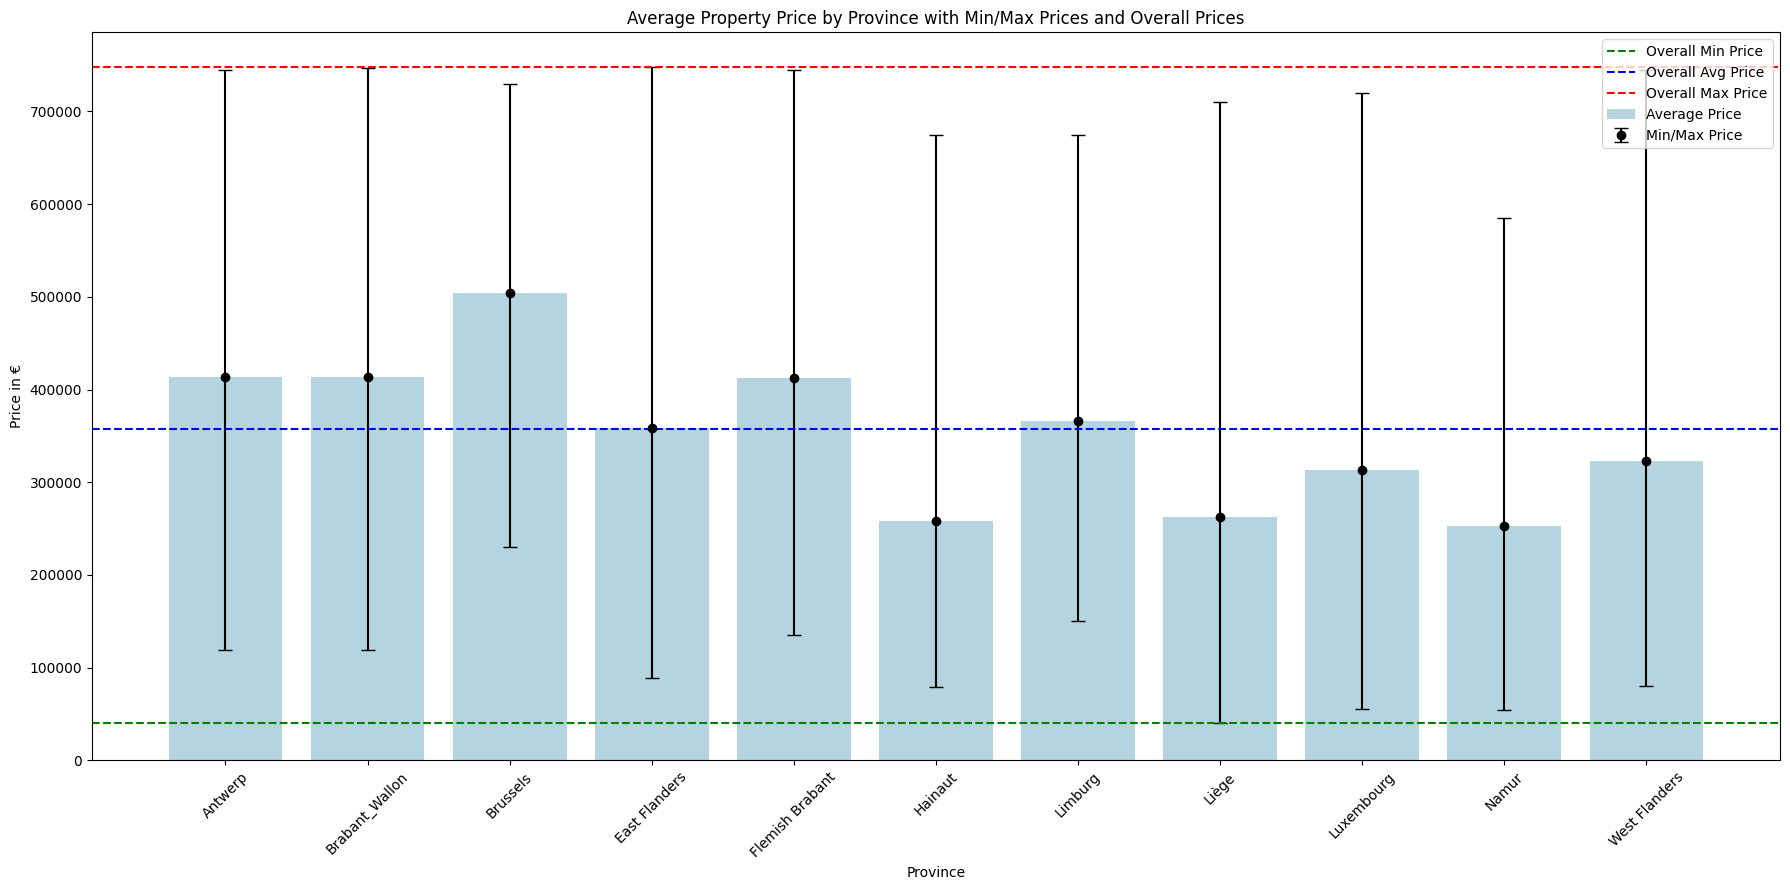

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set options to show all columns
pd.set_option('display.max_columns', None)

# Load CSV file and generate pandas DataFrame
input_csv = r'C:\Users\izama\Desktop\immo-eliza-team6-analysis\immo-eliza-team6-analysis\data\clean\after_step_4_correlation.csv'  # Fill your path to file
df_1 = pd.read_csv(input_csv, sep=',')

# Display the first few rows of the DataFrame
#print(df_1.head())

# Display the count of provinces
#print(df_1['Province'].value_counts())

# Calculate the average, minimum, and maximum prices per province
price_stats = df_1.groupby('Province')['Price'].agg(['mean', 'min', 'max']).sort_index()

# Prepare data for plotting
average_prices = price_stats['mean']
min_prices = price_stats['min']
max_prices = price_stats['max']

# Overall minimum, average, and maximum prices across all regions
overall_min_price = df_1['Price'].min()
overall_avg_price = df_1['Price'].mean()
overall_max_price = df_1['Price'].max()

# Plot the average price by province with sns in a single subplot
fig, ax = plt.subplots(figsize=(18, 9))  # Create a figure with one subplot
sns.barplot(x=average_prices.index, y=average_prices.values, ax=ax, color='lightblue', label='Average Price')

# Add error bars for min and max prices
for i, province in enumerate(average_prices.index):
    ax.errorbar(i, average_prices[province], 
                yerr=[[average_prices[province] - min_prices[province]], 
                       [max_prices[province] - average_prices[province]]],
                fmt='o', color='black', capsize=5, label='Min/Max Price' if i == 0 else "")

# Draw horizontal lines for overall min, average, and max prices
ax.axhline(y=overall_min_price, color='green', linestyle='--', label='Overall Min Price')
ax.axhline(y=overall_avg_price, color='blue', linestyle='--', label='Overall Avg Price')
ax.axhline(y=overall_max_price, color='red', linestyle='--', label='Overall Max Price')

# Set labels and title
ax.set_ylabel('Price in €')
ax.set_xlabel('Province')
ax.set_title('Average Property Price by Province with Min/Max Prices and Overall Prices')

# Rotate x labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))  # Place legend outside of the plot area

# Show the plot
plt.tight_layout()
plt.show()
